### Imports and data loading

In [150]:
import pandas as pd
import backtrader as bt
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

## Data loading

In [ ]:
google_colab = False
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "kLmDPAmiTHNw_cv3lr6wY9DfSt8RSHv"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('05-07_11-26.csv')  
    df_read = pd.read_csv('05-07_11-26.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    sys.path.append(path)

    # Load Model 3 prediction file
    df = pd.read_csv(path + '/data/predictions/05-07_11-26.csv')

### Data processing

In [151]:
df_read = df.copy()

In [152]:
df = df_read.copy()

In [153]:
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'] * 365, unit='D')

In [154]:
# FIlter between 2017-12-26 and 2018-02-01
df = df[(df['Quote_date'] >= '2018-02-01') & (df['Quote_date'] <= '2018-04-30')]
df = df[(df['Expiry_date'] >= '2018-02-01') & (df['Expiry_date'] <= '2018-04-30')]

In [155]:
print(len(df))

147084


Adding ID

In [156]:
df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)

Adding TTM=0 row

In [157]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

# Adding intrinsic value as Price on expirty date
# Iterate over every option, which is identified by the combination of Quote_date, Expiry_date, Strike
groups = df.groupby(['Expiry_date', 'Strike'])
for _, group in groups:
    # Create a new row for the date of expiry
    new_row = group.iloc[-1].copy()
    new_row['Price'] = max(0, new_row['Underlying_last'] - new_row['Strike'])
    new_row['TTM'] = 0
    new_row['Quote_date'] = new_row['Expiry_date']
    df = pd.concat([df, new_row.to_frame().transpose()], ignore_index=True)


# Quote_date and Expiry_date to datetime
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

df_read = df.copy()


### Parameters

In [158]:
buy_threshold = 5
sell_threshold = 13
starting_balance = 1000000

### Functions

In [159]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Price']) >= buy_threshold
    sell_signal = (df['Prediction'] - df['Price']) <= sell_threshold
    return buy_signal, sell_signal

def trader(df, buy_signal, sell_signal, starting_balance):
    # Data
    df["Option_ID"] = df["Expiry_date"].astype(str) + df["Strike"].astype(str)
    last_date = df['Quote_date'].max()
    df = df[pd.to_datetime(df['Expiry_date']) < pd.to_datetime(last_date)]
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Balance'] = starting_balance
    df["Position_this_opt"] = 0

    for quote_date in df['Quote_date'].unique():
        df_temp = df[df['Quote_date'] == quote_date]
        # Shuffle the rows in df_temp randomly
        df_temp = df_temp.sample(frac=1)

        for _, row in df_temp.iterrows():    
            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and option_position == 0 and row['Balance'] >= row['Price'] and row["Quote_date"] != row["Expiry_date"] :
                option_position = 1
                # Position handling
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                # Balance handling
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] - row['Price']

            # Sell the option
            if row['Signal'] == -1 and option_position == 0 and row["Quote_date"] != row["Expiry_date"]:
                option_position = -1
                # Position handling
                df.loc[(df['Quote_date'] >= row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                # Balance handling
                df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] >= row['Quote_date']), 'Balance'] + row['Price']

            # Option expires
            if row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                option_position = 0
                df.loc[(df['Quote_date'] > row['Quote_date']) & (df['Option_ID'] == row['Option_ID']), 'Position_this_opt'] = option_position
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position == 1 else -intrinsic_value
                # Adjust balance - Money becomes available nex day
                df.loc[(df['Quote_date'] > row['Quote_date']), 'Balance'] = df.loc[(df['Quote_date'] > row['Quote_date']), 'Balance'] + adjustment

    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [160]:
df = df_read.copy()
buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
df = trader(df, buy_signal, sell_signal, starting_balance)
df = calculate_options_value(df)

In [ ]:
print("Starting balance", starting_balance)
print("Ending balance", df['Balance'].iloc[-1])
print("Number of trades", df['Signal'].abs().sum())
profit = df['Balance'].iloc[-1] - starting_balance
print("Profit", profit)
print("Profit per trade", profit / df['Signal'].abs().sum())
print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
print("Number of days", num_days)
cagr = (df['Total_value'].iloc[-1] / starting_balance) ** (365 / num_days) - 1
print("CAGR", cagr)



Starting balance 1000000
Ending balance 901905.4349999977
Number of trades 15900
Profit -98094.56500000227
Profit per trade -6.169469496855489
Profit per day -4087.2735416667615
Number of days 24
CAGR -0.7919950820744818


### Analysis

<Axes: title={'center': 'Total value over time'}, xlabel='Quote_date'>

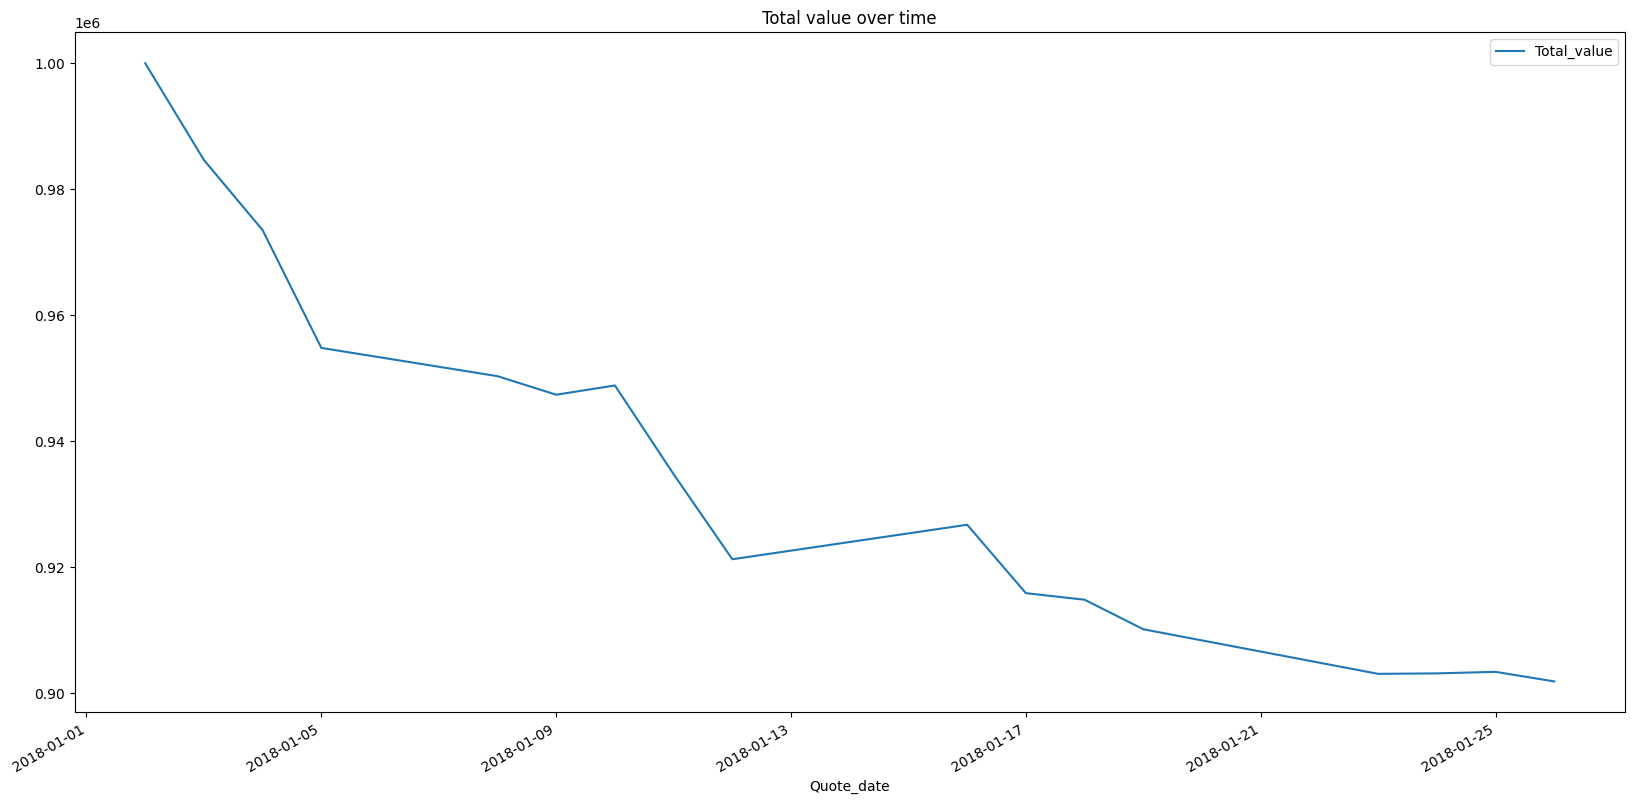

In [ ]:
# Plot total value over time
df_plot = df[['Quote_date', 'Total_value']].copy()
df_plot = df_plot.set_index('Quote_date')
df_plot.plot(figsize=(20, 10), title='Total value over time')

In [ ]:
display(df.sample(20))

,Unnamed: 0,Quote_date,Price,Prediction,Underlying_last,Strike,TTM,R,Expiry_date,Option_ID,Signal,Balance,Position_this_opt,Options_value,Total_value
12455,4156652,2018-01-16,1.905,0.0,2776.53,2820.0,0.021918,0.0133,2018-01-24,2018-01-242820.0,-1,1170851.325,-1,-244085.370,926765.955
3412,4127791,2018-01-04,21.5,26.461145,2723.88,2710.0,0.035616,0.0128,2018-01-17,2018-01-172710.0,-1,1318575.390,-1,-345064.875,973510.515
4447,4131322,2018-01-05,766.1,774.0563,2742.12,1975.0,0.019178,0.0127,2018-01-12,2018-01-121975.0,-1,1318580.530,-1,-363754.415,954826.115
8884,4144035,2018-01-10,174.555,176.6576,2747.98,2575.0,0.024658,0.0131,2018-01-19,2018-01-192575.0,-1,1257157.065,-1,-308288.680,948868.385
1993,4123865,2018-01-03,134.005,135.34117,2712.71,2580.0,0.038356,0.0129,2018-01-17,2018-01-172580.0,-1,1318575.340,-1,-333929.530,984645.810
18097,4185754,2018-01-26,254.33,258.22333,2839.33,2585.0,0,0.0123,2018-01-26,2018-01-262585.0,-1,901905.435,0,0.000,901905.435
15765,4177360,2018-01-23,270.155,273.7033,2839.33,2570.0,0.008219,0.0126,2018-01-26,2018-01-262570.0,-1,997230.875,-1,-94123.830,903107.045
16074,4181484,2018-01-24,364.745,369.66272,2838.21,2475.0,0.005479,0.0125,2018-01-26,2018-01-262475.0,-1,960971.585,-1,-57790.740,903180.845
7867,4140172,2018-01-09,0.1,0.0,2751.78,2910.0,0.035616,0.0127,2018-01-22,2018-01-222910.0,-1,1288047.950,-1,-340647.250,947400.700
3081,4127460,2018-01-04,428.8,432.22113,2723.88,2295.0,0.021918,0.0128,2018-01-12,2018-01-122295.0,-1,1318575.390,-1,-345064.875,973510.515


In [ ]:
import matplotlib.pyplot as plt

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Set x-axis major ticks to weekly interval, on Mondays
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

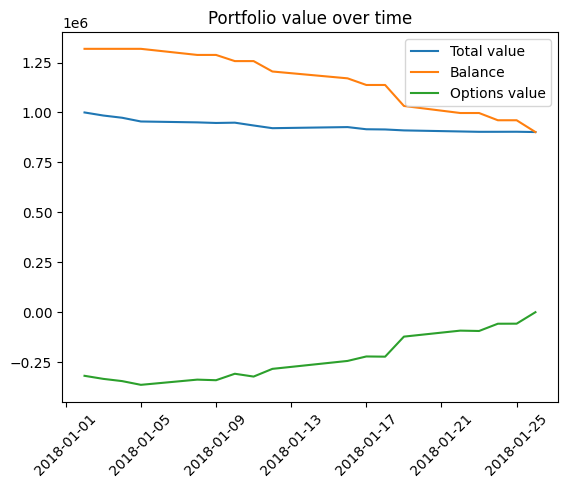

In [ ]:
plot(df)

In [ ]:
import numpy as np

# Calculate the sharpe ratio of the strategy using the daily returns and using df["R"] as the annualised risk-free rate
def sharpe_ratio(df):
    df["Daily_returns"] = df["Total_value"].pct_change()
    sharpe_ratio = np.sqrt(252) * ((df["Daily_returns"].mean() - (df["R"]/252).mean()) / df["Daily_returns"].std())
    return sharpe_ratio

print("Sharpe ratio", sharpe_ratio(df))

# Calculate max drawdown
def max_drawdown(df):
    df["Drawdown"] = df["Total_value"] / df["Total_value"].cummax() - 1
    max_drawdown = df["Drawdown"].min()
    return max_drawdown

print("Max drawdown", max_drawdown(df))

Sharpe ratio -1.593881748674773
Max drawdown -0.09809456500000391


### Finding best thresholds

In [ ]:
# Test many conbinations of sell and buy thresholds to find the one that gives the highest Sharpe ratio
def find_best_thresholds(df, starting_balance):
    best_sharpe = -100
    best_sell = 0
    best_buy = 0
    for sell in range(5, 25, 5):
        for buy in range(5, 25, 5):
            df = df_read.copy()
            buy_signal, sell_signal = generate_buy_sell_signals(df, buy, sell)
            df = trader(df, buy_signal, sell_signal, starting_balance)
            df = calculate_options_value(df)
            sharpe = sharpe_ratio(df)
            # Print and plot the results
            print("Buy threshold", buy, "Sell threshold", sell, "Sharpe ratio", sharpe)
            print("Starting balance", starting_balance, "Ending balance", df['Balance'].iloc[-1])
            print("Anualiased return", (df['Balance'].iloc[-1] / starting_balance - 1) * 252 / len(df))
            plot(df)
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_sell = sell
                best_buy = buy
    return best_sharpe, best_sell, best_buy

#best_sharpe, best_sell, best_buy = find_best_thresholds(df_read, starting_balance)
#print("Best Sharpe ratio", best_sharpe, "Best sell threshold", best_sell, "Best buy threshold", best_buy)